#Mounting Google Drive for easy access to Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

#Making a DataPreprocessor Class for all the reuired functions

In [ ]:
class DataPreprocessor:
    def __init__(self, interactions_path, metadata_path):
        self.interactions_path = interactions_path
        self.metadata_path = metadata_path

    def load_data(self):
        """Load and perform initial preprocessing of the data"""
        # Load datasets
        self.interactions_df = pd.read_csv(self.interactions_path)
        self.metadata_df = pd.read_csv(self.metadata_path)

        # Convert timestamp columns for interactions_df
        for col in ['updated_at']:
            if col in self.interactions_df.columns:
                self.interactions_df[col] = pd.to_datetime(self.interactions_df[col])

        # Convert timestamp columns for metadata_df
        for col in ['updated_at', 'published_at']:
            if col in self.metadata_df.columns:
                self.metadata_df[col] = pd.to_datetime(self.metadata_df[col])

        # Standardize column name for read percentage
        self.interactions_df['read_percentage'] = self.interactions_df['read_percent']
        self.interactions_df.drop(columns=['read_percent'], inplace=True)

        return self.interactions_df, self.metadata_df

    def clean_data(self):
        """Clean the data and handle missing values"""
        # Remove duplicates and drop missing values
        self.interactions_df = self.interactions_df.drop_duplicates().dropna()
        self.metadata_df = self.metadata_df.drop_duplicates().dropna()

        # Ensure read_percentage is between 0 and 100
        self.interactions_df = self.interactions_df[
            (self.interactions_df['read_percentage'] >= 0) &
            (self.interactions_df['read_percentage'] <= 100)
        ]

        return self.interactions_df, self.metadata_df

    def create_features(self):
        """Create additional features for the recommendation system"""
        # Add temporal features
        self.interactions_df['interaction_hour'] = self.interactions_df['updated_at'].dt.hour
        self.interactions_df['interaction_day'] = self.interactions_df['updated_at'].dt.day_name()

        # Calculate story age in days
        self.metadata_df['story_age_days'] = (
            self.metadata_df['updated_at'] - self.metadata_df['published_at']
        ).dt.days

        # Create user reading preferences by merging with metadata
        user_preferences = self.interactions_df.merge(
            self.metadata_df[['pratilipi_id', 'category_name', 'reading_time']],
            on='pratilipi_id',
            how='left'
        )

        # Calculate user reading statistics
        user_stats = user_preferences.groupby('user_id').agg({
            'read_percentage': ['mean', 'std'],
            'reading_time': ['mean', 'std'],
            'pratilipi_id': 'count'
        }).round(2)

        user_stats.columns = [
            'avg_read_percentage', 'std_read_percentage',
            'avg_reading_time', 'std_reading_time',
            'total_interactions'
        ]

        # Merge user stats back into interactions dataframe
        self.interactions_df = self.interactions_df.merge(
            user_stats,
            left_on='user_id',
            right_index=True
        )

        return self.interactions_df, self.metadata_df

    def plot_read_percentage_distribution(self):
        """Plot the distribution of reading percentage"""
        Path('plots').mkdir(exist_ok=True)
        plt.figure(figsize=(10, 6))
        sns.histplot(data=self.interactions_df, x='read_percentage', bins=50)
        plt.title('Distribution of Reading Percentage')
        plt.savefig('plots/reading_percentage_dist.png')
        plt.show()
        plt.close()

    def plot_category_distribution(self):
        """Plot the distribution of story categories"""
        Path('plots').mkdir(exist_ok=True)
        category_counts = self.metadata_df['category_name'].value_counts()
        plt.figure(figsize=(12, 6))
        category_counts.plot(kind='bar')
        plt.title('Distribution of Story Categories')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('plots/category_dist.png')
        plt.show()
        plt.close()

    def plot_user_activity_patterns(self):
        """Plot user activity by hour of day"""
        Path('plots').mkdir(exist_ok=True)
        hourly_activity = self.interactions_df['interaction_hour'].value_counts().sort_index()
        plt.figure(figsize=(10, 6))
        hourly_activity.plot(kind='line', marker='o')
        plt.title('User Activity by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Number of Interactions')
        plt.savefig('plots/hourly_activity.png')
        plt.show()
        plt.close()

    def plot_reading_time_vs_percentage(self):
        """Plot reading time vs. read percentage"""
        Path('plots').mkdir(exist_ok=True)
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=self.interactions_df.merge(
                self.metadata_df[['pratilipi_id', 'reading_time']],
                on='pratilipi_id'
            ),
            x='reading_time',
            y='read_percentage',
            alpha=0.5
        )
        plt.title('Reading Time vs. Read Percentage')
        plt.savefig('plots/reading_time_vs_percentage.png')
        plt.show()
        plt.close()

    # Additional EDA graphs

    def plot_daily_interactions(self):
        """Plot daily interactions over time"""
        Path('plots').mkdir(exist_ok=True)
        self.interactions_df['interaction_date'] = self.interactions_df['updated_at'].dt.date
        daily_counts = self.interactions_df.groupby('interaction_date').size()
        plt.figure(figsize=(12, 6))
        daily_counts.plot(kind='line', marker='o')
        plt.title('Daily User Interactions Over Time')
        plt.xlabel('Date')
        plt.ylabel('Number of Interactions')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('plots/daily_interactions.png')
        plt.show()
        plt.close()

    def plot_reading_time_distribution(self):
        """Plot distribution of reading time from metadata"""
        Path('plots').mkdir(exist_ok=True)
        plt.figure(figsize=(10, 6))
        sns.histplot(data=self.metadata_df, x='reading_time', bins=50)
        plt.title('Distribution of Reading Time')
        plt.xlabel('Reading Time (seconds)')
        plt.savefig('plots/reading_time_distribution.png')
        plt.show()
        plt.close()

    def plot_avg_read_percentage_by_category(self):
        """Plot average reading percentage by story category"""
        Path('plots').mkdir(exist_ok=True)
        merged_df = self.interactions_df.merge(
            self.metadata_df[['pratilipi_id', 'category_name']],
            on='pratilipi_id',
            how='left'
        )
        avg_read = merged_df.groupby('category_name')['read_percentage'].mean().sort_values()
        plt.figure(figsize=(12, 6))
        avg_read.plot(kind='bar')
        plt.title('Average Reading Percentage by Category')
        plt.xlabel('Category')
        plt.ylabel('Average Reading Percentage')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('plots/avg_read_percentage_by_category.png')
        plt.show()
        plt.close()

    def plot_day_of_week_activity(self):
        """Plot interactions by day of the week"""
        Path('plots').mkdir(exist_ok=True)
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_counts = self.interactions_df['interaction_day'].value_counts().reindex(day_order)
        plt.figure(figsize=(10, 6))
        day_counts.plot(kind='bar', color='skyblue')
        plt.title('Interactions by Day of the Week')
        plt.xlabel('Day of Week')
        plt.ylabel('Number of Interactions')
        plt.tight_layout()
        plt.savefig('plots/day_of_week_activity.png')
        plt.show()
        plt.close()

    def plot_boxplot_read_percentage_by_category(self):
        """Plot boxplot of reading percentage for each category"""
        Path('plots').mkdir(exist_ok=True)
        merged_df = self.interactions_df.merge(
            self.metadata_df[['pratilipi_id', 'category_name']],
            on='pratilipi_id',
            how='left'
        )
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=merged_df, x='category_name', y='read_percentage')
        plt.title('Reading Percentage by Category')
        plt.xlabel('Category')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('plots/boxplot_read_percentage_by_category.png')
        plt.show()
        plt.close()

    def plot_correlation_heatmap(self):
        """Plot a correlation heatmap of numerical features"""
        Path('plots').mkdir(exist_ok=True)
        merged_df = self.interactions_df.merge(
            self.metadata_df[['pratilipi_id', 'reading_time', 'story_age_days']],
            on='pratilipi_id',
            how='left'
        )
        numeric_cols = [
            'read_percentage', 'interaction_hour', 'avg_read_percentage', 'std_read_percentage',
            'avg_reading_time', 'std_reading_time', 'total_interactions', 'reading_time', 'story_age_days'
        ]
        corr_matrix = merged_df[numeric_cols].corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap of Numerical Features')
        plt.tight_layout()
        plt.savefig('plots/correlation_heatmap.png')
        plt.show()
        plt.close()

    def plot_stories_per_author(self):
        """Plot number of stories per author"""
        Path('plots').mkdir(exist_ok=True)
        author_counts = self.metadata_df['author_id'].value_counts()
        plt.figure(figsize=(12, 6))
        author_counts.plot(kind='bar')
        plt.title('Number of Stories per Author')
        plt.xlabel('Author ID')
        plt.ylabel('Number of Stories')
        plt.tight_layout()
        plt.savefig('plots/stories_per_author.png')
        plt.show()
        plt.close()

# Initializing the Preprocessor

In [ ]:
# Initialize preprocessor
preprocessor = DataPreprocessor(
    interactions_path='/content/drive/MyDrive/dataset/user_interaction.csv',
    metadata_path='/content/drive/MyDrive/dataset/metadata.csv'
)

# Loading and Cleaning the Data

In [ ]:
# Load data
interactions_df, metadata_df = preprocessor.load_data()
print("Data loaded successfully")

# Clean data
interactions_df, metadata_df = preprocessor.clean_data()
print("Data cleaned successfully")

Data loaded successfully
Data cleaned successfully


# Creating Some useful features from exisiting ones

In [ ]:
# Create features
interactions_df, metadata_df = preprocessor.create_features()
print("Features created successfully")

print("Interactions df: ")
print(interactions_df.info())

print("Metadata df: ")
print(metadata_df.info())

Features created successfully
Interactions df: 
<class 'pandas.core.frame.DataFrame'>
Index: 2499976 entries, 0 to 2499999
Data columns (total 11 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              int64         
 1   pratilipi_id         int64         
 2   updated_at           datetime64[ns]
 3   read_percentage      float64       
 4   interaction_hour     int32         
 5   interaction_day      object        
 6   avg_read_percentage  float64       
 7   std_read_percentage  float64       
 8   avg_reading_time     float64       
 9   std_reading_time     float64       
 10  total_interactions   int64         
dtypes: datetime64[ns](1), float64(5), int32(1), int64(3), object(1)
memory usage: 219.3+ MB
None
Metadata df: 
<class 'pandas.core.frame.DataFrame'>
Index: 954494 entries, 0 to 954500
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   ---

# As you can see the amount of data is too much to process on a personal system or a free cloud system, so we will probably be using a small portion of the original data to make the Recommendation System

In [ ]:
# Print user interaction counts
user_counts = interactions_df.groupby('user_id').size()
print("\nNumber of interactions per user:")
print(user_counts)
print("\nSummary statistics of interactions per user:")
print(user_counts.describe())


Number of interactions per user:
user_id
3257552805995172     6
3257621147984548     2
3260243929637540     1
3260275089121956    37
3260433621754532     2
                    ..
5506791996685224     1
5506791996685251     1
5506791996685282     1
5506791996685286     1
5506791996685385     1
Length: 243601, dtype: int64

Summary statistics of interactions per user:
count    243601.000000
mean         10.262585
std          18.075198
min           1.000000
25%           1.000000
50%           3.000000
75%          11.000000
max         470.000000
dtype: float64


# As you can notice, the data is very sparse in terms of interactions per user

# Now let's plot some graphs

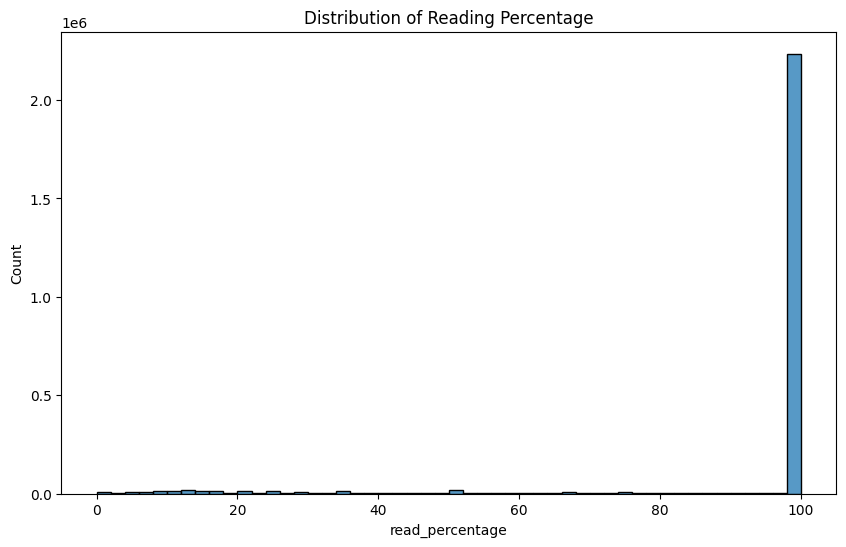

In [ ]:
preprocessor.plot_read_percentage_distribution()

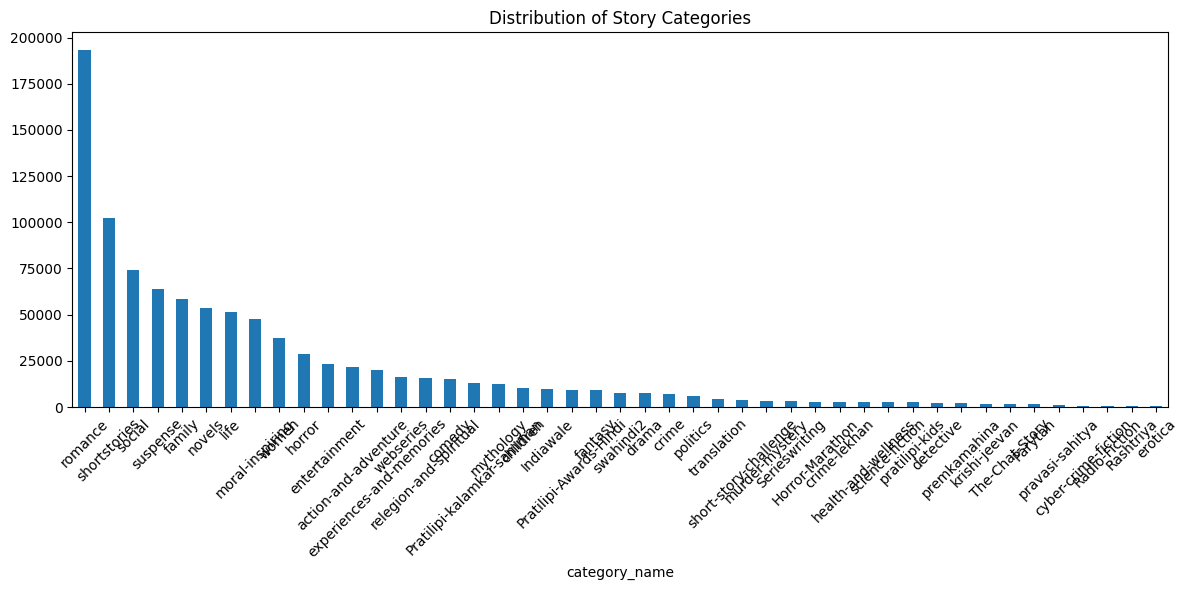

In [ ]:
preprocessor.plot_category_distribution()

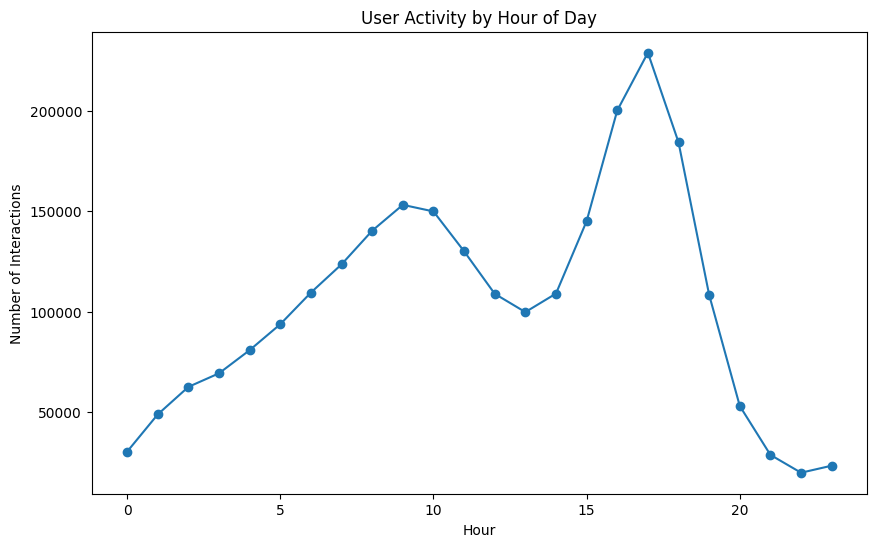

In [ ]:
preprocessor.plot_user_activity_patterns()

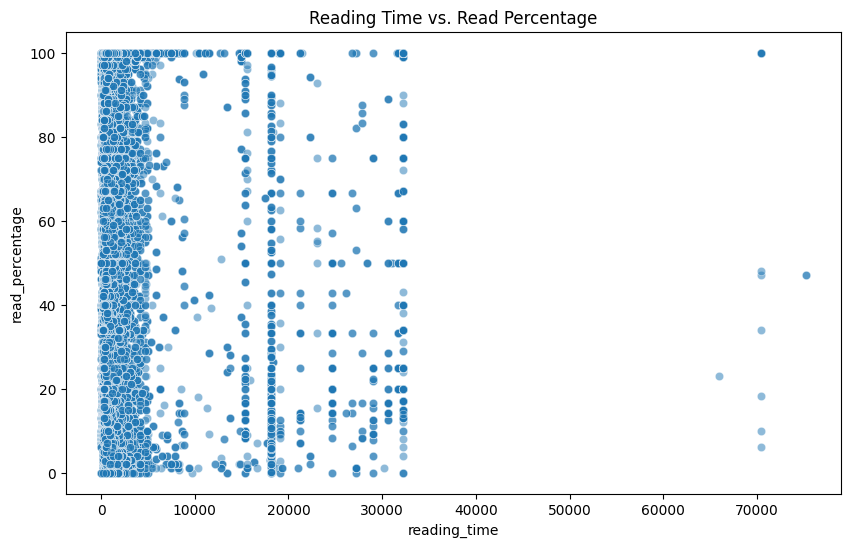

In [ ]:
preprocessor.plot_reading_time_vs_percentage()

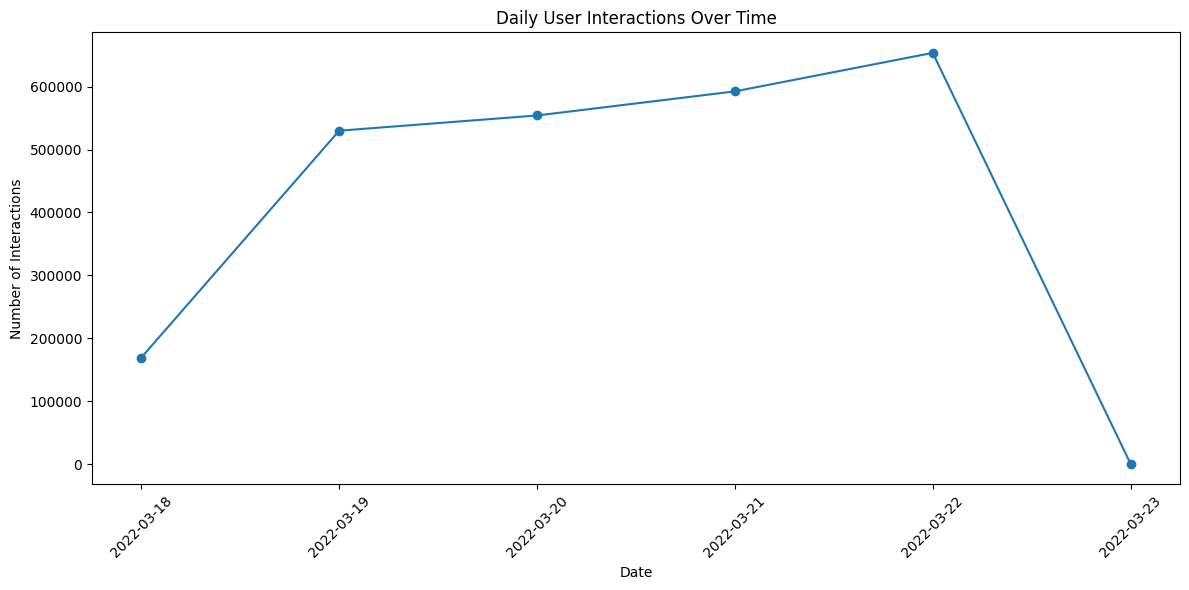

In [ ]:
preprocessor.plot_daily_interactions()

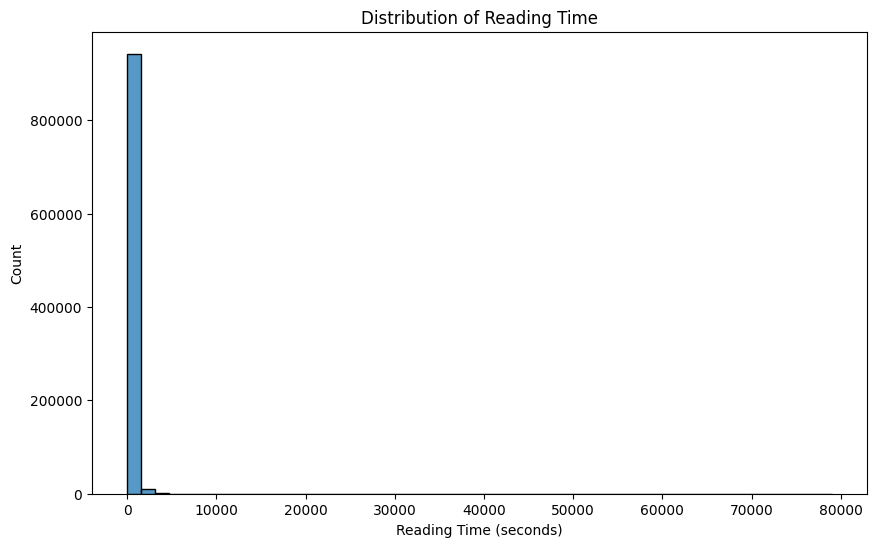

In [ ]:
preprocessor.plot_reading_time_distribution()

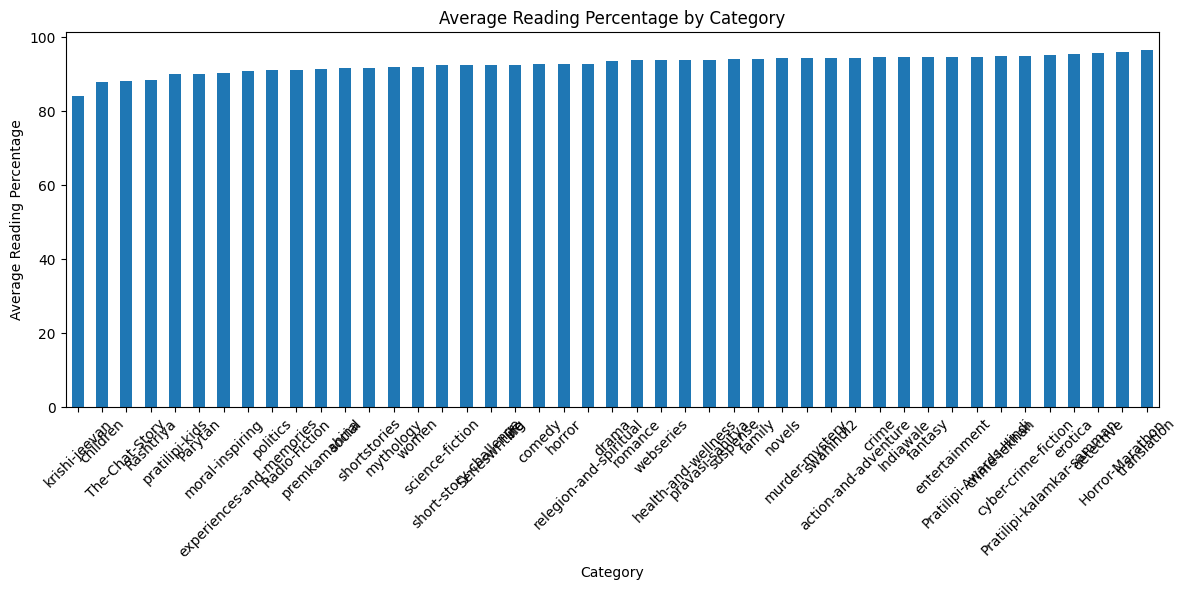

In [ ]:
preprocessor.plot_avg_read_percentage_by_category()

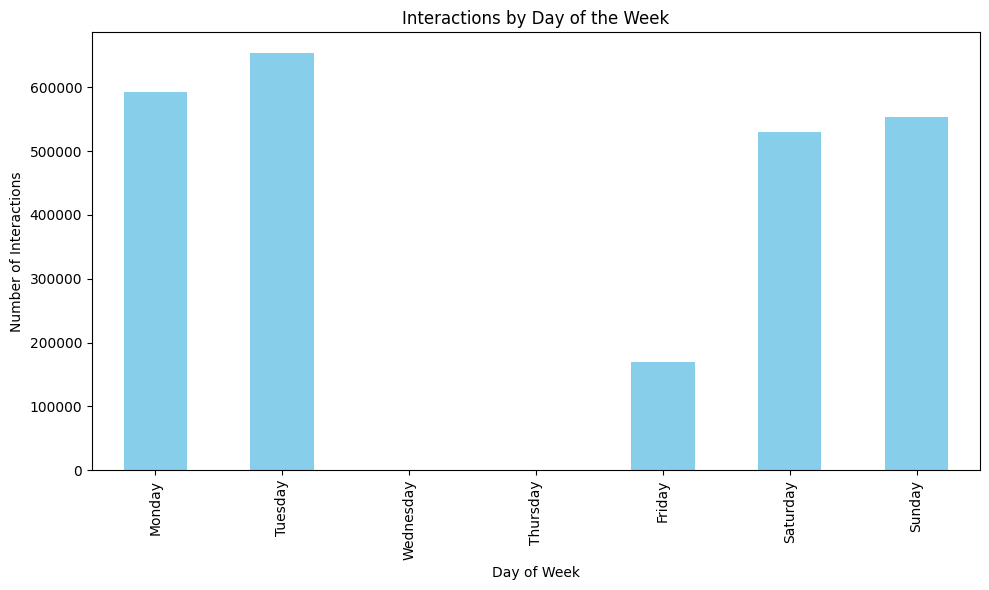

In [ ]:
preprocessor.plot_day_of_week_activity()

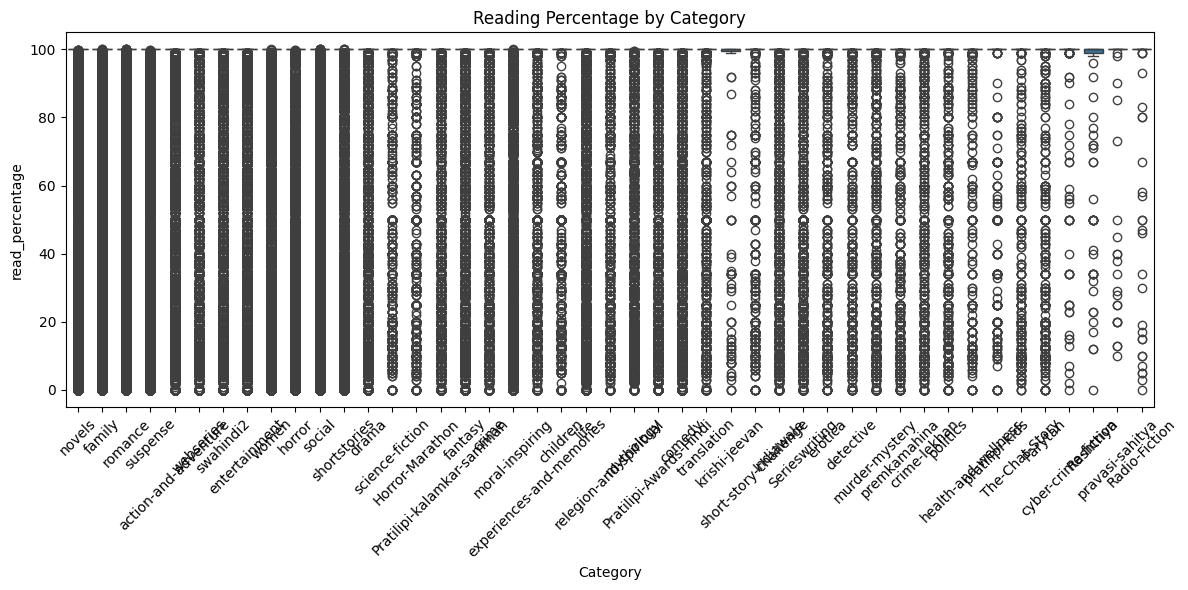

In [ ]:
preprocessor.plot_boxplot_read_percentage_by_category()

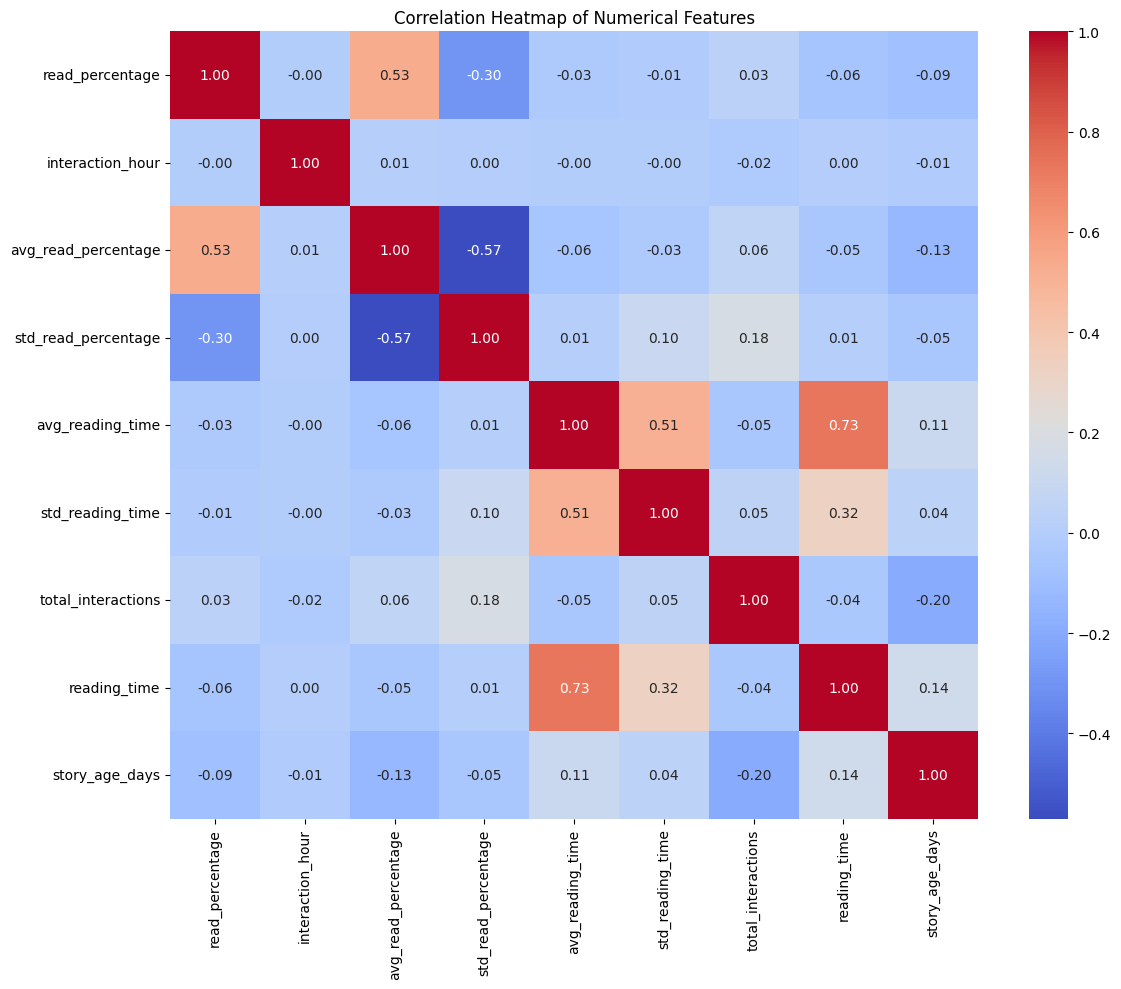

In [ ]:
preprocessor.plot_correlation_heatmap()

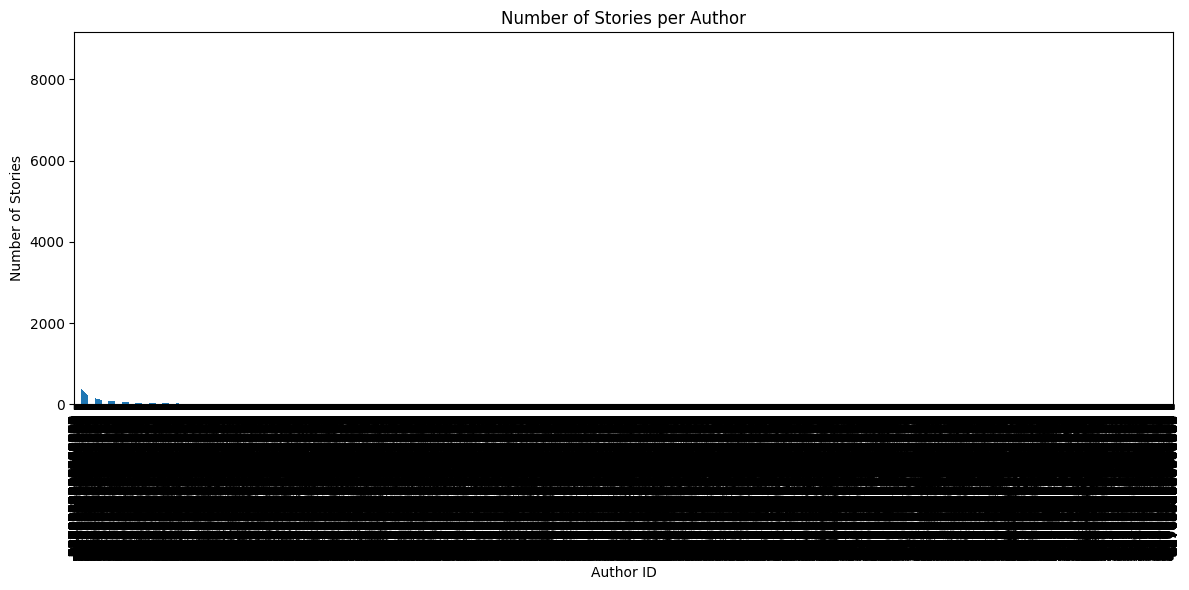

In [ ]:
preprocessor.plot_stories_per_author()